In [1]:
# stdlib imports
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 8")

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
from obspy import read
from obspy.signal.invsim import corn_freq_2_paz, simulate_seismometer

# local imports
from amptools.io.read import read_data
from pgm.oscillators import get_spectral, calculate_spectrals

%matplotlib inline

# Creating and optimizing a spectral amplitude response algorithm

In [2]:
# Test data
sac_file = '../tests/data/process/UW.BRKS..ENE.SAC'
result_file = '../tests/data/process/UW.BRKS..ENE.psa'
stream = read(sac_file)
trace = stream[0]
periods, sas = np.genfromtxt(result_file, unpack=True, usecols=(0, 1))

0.0005269578652087704 1.136752 199.81466011955487
0.0001414278780067479 2.229939 199.97463268566668
6.716279542724588e-05 1.927996 199.98606626655743
2.7278898099266212e-05 1.805717 199.9939573064873
8.757406865727615e-06 1.304918 199.99731558669757
3.1581928868874346e-06 0.565608 199.99776652716895
1.8342373588190956e-06 0.1001898 199.99267708377937
9.703546237206445e-07 0.04986167 199.99221577825145
4.363568900212673e-07 0.01976554 199.9911695353239


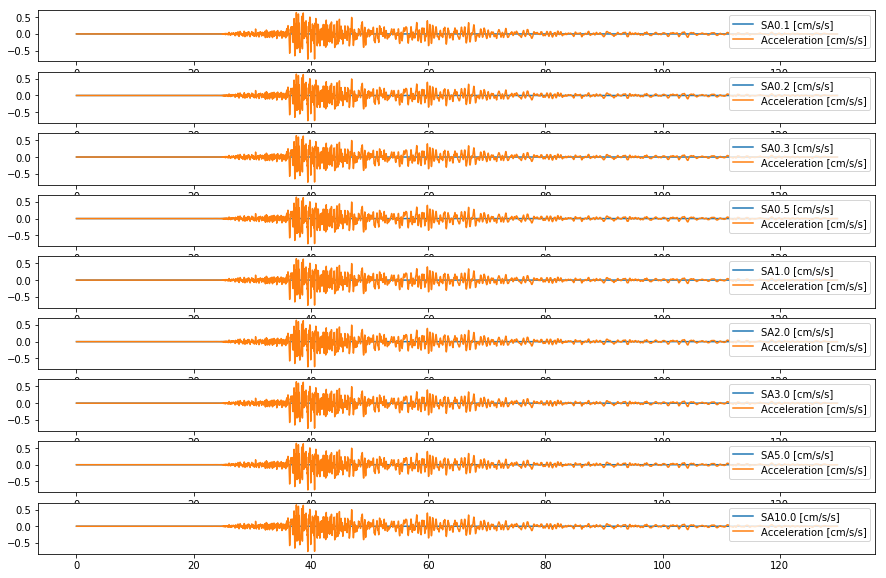

In [13]:
fig, axes = plt.subplots(len(periods), 1, figsize=(15, 10))
damping = 0.05
dt = trace.stats.delta
for period, sa, ax in zip(periods, sas, axes):
    acc = trace.data
    npoints = len(acc)
    initialdisp = 0
    initialvel = 0
    csi = 0.05
    d = np.zeros(npoints)
    v = np.zeros(npoints)
    a = np.zeros(npoints)

    d[0] = initialdisp
    v[0] = initialvel

    w = 2*np.pi/period
    ww = w**2
    csicsi = csi**2
    dcsiw = 2.*csi*w
    damp = 0.05
    sqrtd = np.sqrt( 1- damp**2)
    rcsi = np.sqrt(1-csicsi)
    csircs = csi/rcsi 
    wd = w * sqrtd
    ueskdt = -1./(ww*dt)
    dcsiew = 2.*csi/w
    um2csi = (1.-2*csicsi)/wd
    e = np.exp(-w*dt*csi)
    sin = np.sin(wd*dt)
    cos = np.cos(wd*dt)
    a[0] = - w**2 * d[0] - 2. * damp * w * v[0]

    for i in np.arange(1, 5):
        d[i]  = ca*d[i-1]+cb*v[i-1]+cc*acc[i-1]+cd*acc[i]
        v[i]  = cap*d[i-1]+cbp*v[i-1]+ccp*acc[i-1]+cdp*acc[i]
        a[i] = -ww*d[i]-dcsiw*v[i]

    ax.plot(trace.times(), a, label='SA' + str(period) + ' [cm/s/s]')
    ax.plot(trace.times(), trace.data, label='Acceleration [cm/s/s]')
    maxy = np.max(np.abs(a))
    print(maxy, sa, np.abs(maxy - sa)/ ((maxy + sa) * 0.5) * 100)
    legend = ax.legend()


In [ ]:
fig, axes = plt.subplots(len(periods), 1, figsize=(15, 10))
damping = 0.05
for period, sa, ax in zip(periods, sas, axes):
    acc_sa = calculate_spectrals(trace.times(), trace.data, period, damping)[0]
    ax.plot(trace.times(), acc_sa, label='SA' + str(period) + ' [cm/s/s]')
    ax.plot(trace.times(), trace.data, label='Acceleration [cm/s/s]')
    print(np.max(np.abs(acc_sa)), sa)
    legend = ax.legend()
    

In [ ]:
fig, axes = plt.subplots(len(periods), 1, figsize=(15, 10))
damping = 0.05
for period, sa, ax in zip(periods, sas, axes):
    samp_rate = trace.stats.sampling_rate
    T = period
    freq = 1.0 / T
    omega = (2 * 3.14159 * freq) ** 2
    paz_sa = corn_freq_2_paz(freq, damp=damping)
    paz_sa['sensitivity'] = omega
    paz_sa['zeros'] = []
    dd = simulate_seismometer(trace.data, samp_rate,
                                                  paz_remove=None,
                                                  paz_simulate=paz_sa,
                                                  taper=True,
                                                  simulate_sensitivity=True,
                                                  taper_fraction=0.05)
    ax.plot(trace.times(), dd, label='SA' + str(period) + ' [cm/s/s]')
    ax.plot(trace.times(), trace.data, label='Acceleration [cm/s/s]')
    print(np.max(np.abs(dd)), sa)
    legend = ax.legend()

In [ ]:
fig, axes = plt.subplots(len(periods), 1, figsize=(15, 10))
damping = 0.05
for period, sa, ax in zip(periods, sas, axes):
    w0 = 2 * np.pi / period
    times = trace.times()
    a = trace.data
    n = len(trace.data)
    damping = 0.05
    d = np.zeros(n)
    v = np.zeros(n)
    z = np.zeros(n)

    sqrtd = np.sqrt(1-damping**2)

    for i in range(0, n -1):
        t0 = times[i]
        t1 = times[i+1]
        tau = t1-t0
        wd = w0 * sqrtd
        exp = np.exp(-1 * damping * w0 * tau)
        cos = np.cos(wd * tau)
        sin = np.sin(wd * tau)

        a11 = exp * ((damping / sqrtd)* sin + cos)
        a12 = (exp / (w0 * sqrtd)) * sin
        a21 = -1 * (w0 / sqrtd) * exp * sin
        a22 = exp * (cos - (damping / sqrtd) * sin)

        b11 = exp * (((2 * damping**2 - 1) / (tau * w0**2) + damping / w0) * (sin / w0 * sqrtd) + \
                (2 * damping / (tau * w0**3) + 1 / w0**2) * cos) - 2 * damping / (tau * w0**3)
        b12 = -1 * exp * ((2 * damping**2 - 1) / (tau * w0**2) * sin / (w0 * sqrtd) + \
                2 * damping / (tau * w0**3) * cos) - 1 / w0**2 + 2 * damping / (tau * w0**3)
        b21 = exp * (((2 * damping**2 - 1) / (tau * w0**2) + damping / w0) * (cos  - \
                (damping / sqrtd) * sin) - (2 * damping / (tau * w0**3) + 1/w0**3)* (w0 * sqrtd * sin + \
                damping * w0 * cos)) + 1 / (tau * w0 **2)
        b22 = -1 * exp * ((2 * damping - 1) / (tau * w0**2) * (cos - (damping / sqrtd) * sin) - \
                2 * damping / (tau * w0**3) * (w0 * sqrtd * sin + damping * w0 * cos)) - 1 / (tau * w0**2)


        A = [[a11, a12], [a21, a22]]
        B = [[b11, b12], [b21, b22]]



        if i == 0:
            xx = [[d[i], v[i]]]
            aa = [[a[i], a[i+1]]]
            x_bar = np.asarray(xx)
            a_bar = np.asarray(aa)
        else:
            x_bar = np.append(x_bar, [[d[i], v[i]]], axis=0)
            a_bar = np.append(a_bar, [[a[i], a[i+1]]], axis=0)
        xi = x_bar[i].reshape(2, 1)
        ai = a_bar[i].reshape(2, 1)
        x_bar = np.append(x_bar, [(np.dot(A , xi) + np.dot(B , ai)).reshape(2)], axis=0)
        d[i+1] = x_bar[i+1][0]
        v[i+1] = x_bar[i+1][1]
        z[i+1] = -1 * (2 * damping * w0 * x_bar[i+1][1] + x_bar[i+1][0] * w0**2) - a[i]
    ax.plot(trace.times(), z, label='SA' + str(period) + ' [cm/s/s]')
    ax.plot(trace.times(), trace.data, label='Acceleration [cm/s/s]')
    print(np.max(np.abs(z)), sa)
    legend = ax.legend()

In [ ]:

nsamp = len(trace.data)
acc = trace.data.copy()
kug = nsamp - 1
kg = nsamp
dt_in = trace.stats.delta
d = damping
w = 2 * np.pi / period
pr = 2 * np.pi/w

nn = 1
wd = np. sqrt(1. -d * d) * w
w2 = w * w
w3 = w2 * w
x = np.zeros((2,3))
z = np.zeros(nsamp)
disp = np.zeros(nsamp)
vel = np.zeros(nsamp)

f2 = 1.  /  w2
f3 = d * w
f4 = 1.  /  wd
f5 = f3 * f4
f6 = 2.  * f3

ns =  int(10.  * dt_in /  pr - 0.01) +  1
dt = dt_in /  (ns)

for k in range(kug):
    f1 = 2.  * d /  w3 /  dt
    e = np. exp(-f3 * dt)
    g1 = e * np. sin(wd * dt)
    g2 = e * np. cos(wd * dt)
    h1 = wd * g2-f3 * g1
    h2 = wd * g1 +  f3 * g2
    dug = (acc[k +  1]-acc[k]) /  (ns)
    g = acc[k]
    z1 = f2 * dug
    z3 = f1 * dug
    z4 = z1 /  dt

    for ii in range(ns):
        z2 = f2 * g
        b = x[0,0] +  z2-z3
        a = f4 * x[0,1] +  f5 * b +  f4 * z4
        x[1, 0] = a * g1 +  b * g2 +  z3-z2-z1
        x[1,1] = a * h1-b * h2-z4
        x[1, 2] = -f6 * x[1,1] - w2 * x[1, 0]
        nn  =  nn  +   1
        disp[ii] += [x[1,0]]
        vel[ii] += [x[1,1]]
        z[ii] += [x[1,2]]
        for j in range(3):
            x[0,j] = x[1,j]
        g = g +  dug
plt.plot(z)